In [2]:
import matplotlib.pyplot as plt
import numpy as np
import blip_analysis as ba
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
import exp_blip_models as em
import matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix
import sys
sys.path.append('/home/camp/warnert/label_axes')
from label_axes import label_axes
import scipy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [3]:
full_res = pickle.Unpickler(open('230315_full_classifier_RFs.pkl', 'rb')).load()
glyphs = ba.get_glyphs()

In [8]:
print(full_res.shape)

(3, 100, 2)


In [4]:
scores = full_res[:, :, 0].astype(float)
preds = full_res[:, :, 1]


In [8]:
preds_corrected = np.array([[np.stack(i) for i in j] for j in preds])
preds_flat = preds_corrected.reshape((preds_corrected.shape[0], preds_corrected.shape[1] * preds_corrected.shape[2]))
print(preds_flat.shape)


(3, 3200)


In [9]:
trues = [i for j in range(100) for i in range(32)]
cms = np.array([confusion_matrix(trues, preds_flat[i], normalize='true') for i in range(3)])

<Figure size 432x288 with 0 Axes>

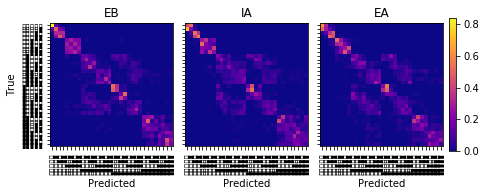

In [10]:
#plt.imshow(cm, cmap=plt.cm.plasma)
fig = plt.figure()
# gs = GridSpec(1, 3, left=0.03, right=0.97, bottom=0.03, top=0.97, wspace=0.2, hspace=0.1)
# axs = [fig.add_subplot(gs[i]) for i in range(3)]
# global_vmax = np.max([np.max(np.abs(cms[i])) for i in range(3)])
# [axs[i].imshow(cms[i]) for i in range(3)]
# [axs[i].set_xticks(range(32)) for i in range(3)]
# [axs[i].set_yticks(range(32)) for i in range(3)]
# [axs[i].set_yticklabels([]) for i in range(1, 3)]
# [axs[i].set_ylim(31.5, -0.5) for i in range(3)]
# axs[0].set_yticklabels(glyphs)
# [axs[i].set_xticklabels(glyphs, rotation=90) for i in range(3)];

def plot_heatmap(ax, data, title, vmax, cmap='plasma', fontsize=8):
    im = ax.imshow(data, cmap=cmap, vmin=0, vmax=vmax)
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    ax.set_yticklabels([])
    ax.set_ylim(31.5, -0.5)
    ax.set_title(title)
    ax.set_xticklabels(glyphs, rotation=90, fontsize=fontsize)
    ax.set_xlabel('Predicted')
    return im

def plot_all_heatmaps(fig, glob_gs, cms, fontsize=8):
    gs = glob_gs.subgridspec(1, 3, wspace=0.1)
    axs = [fig.add_subplot(gs[i]) for i in range(3)]
    global_vmax = np.max([np.max(np.abs(cms[i])) for i in range(3)])
    titles = ['EB', 'IA', 'EA']
    ims = [plot_heatmap(axs[i], cms[i], titles[i], global_vmax, fontsize=fontsize) for i in range(3)]
    axs[0].set_yticklabels(glyphs, fontsize=fontsize)
    axs[0].set_ylabel('True')
    
    return ims, axs
fig = plt.figure()
gs = GridSpec(1, 31, left=0.03, right=0.97, bottom=0.03, top=0.97, wspace=1, hspace=0.1)
ims, axs = plot_all_heatmaps(fig, gs[:-1], cms)
cbar_ax = fig.add_subplot(gs[-1], aspect=20)
cbar = fig.colorbar(ims[0], cax=cbar_ax)

In [11]:
mean_acc = [np.mean(np.diag(cms[i])) for i in range(3)]
std_acc = [np.std(np.diag(cms[i])) for i in range(3)]
print(mean_acc)
print(std_acc)
print(1/32)
for i in range(3):
    print(f'${mean_acc[i]:.2f} \pm {std_acc[i]:.2f}$')

[0.245, 0.203125, 0.2134375]
[0.16931848688197046, 0.1360247564783705, 0.141213698321905]
0.03125
$0.24 \pm 0.17$
$0.20 \pm 0.14$
$0.21 \pm 0.14$


In [12]:
res1 = np.load('../Fig2/221026_de_1d_res_odour1_extended.npy')
res2 = np.load('../Fig2/221027_de_1d_res_odour2_extended.npy')
res3 = np.load('../Fig2/221027_de_1d_res_odour3_extended.npy')
res1 = np.array(res1).reshape(50, 162, 32)
res2 = np.array(res2).reshape(50, 162, 32)
res3 = np.array(res3).reshape(50, 162, 32)

In [13]:
def flip_distances(distances):
    distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
    distances_flipped = [distances_normed[0]]
    for i in range(1, len(distances)):
        prev_distance = distances_flipped[-1]
        distance = distances_normed[i]
        if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
            distances_flipped.append(distance)
        else:
            distances_flipped.append(-distance)
    return distances_flipped

def flip_flip_distances(distances):
    #flipped_distances = np.array([flip_distances(i) for i in distances])
    flipped_flipped_distances = [distances[0]]

    for i in range(1, len(distances)):
        if np.sum(np.abs(distances[0]+distances[i])) > np.sum(np.abs(distances[0]-distances[i])):
            flipped_flipped_distances.append(distances[i])
        else:
            flipped_flipped_distances.append(-distances[i])
    return np.array(flipped_flipped_distances)

In [14]:
flipped_distance = flip_flip_distances(res1)

In [15]:
closests1 = [res1[0, 0]]
closests2 = [res2[0, 0]]
closests3 = [res3[0, 0]]
for i in range(1, 162):
    prev_distance = closests1[-1]
    diffs = np.mean(np.abs(res1[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests1.append(res1[min_diff, i])
    
    prev_distance = closests2[-1]
    diffs = np.mean(np.abs(res2[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests2.append(res2[min_diff, i])
    
    prev_distance = closests3[-1]
    diffs = np.mean(np.abs(res3[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests3.append(res3[min_diff, i])

32
32
32
32


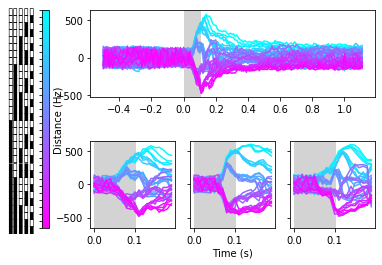

In [16]:
def plot_1d_distance_graph(xs, distances, ax, colors=None, cmap=matplotlib.cm.plasma):
    distances = np.array(distances)
    trial_len = distances.shape[1]
    if colors is None:
        colors = [cmap(i/trial_len) for i in range(trial_len)]

    print(len(colors))
    for index, i in enumerate(distances.T):
        ax.plot(xs, i, color=colors[index])
    ax.axvspan(0, 0.1, color='lightgray')
    
def distance_plots(fig, gs_base, xs, closests, cmap=matplotlib.cm.plasma, hspace=0.5):

    sub_gridspec = gs_base.subgridspec(ncols=14, nrows=2, wspace=1.5, hspace=hspace)
    big_ax = fig.add_subplot(sub_gridspec[0, 2:])
    small_ax1 = fig.add_subplot(sub_gridspec[1, 2:6])
    small_ax2 = fig.add_subplot(sub_gridspec[1, 6:10])
    small_ax3 = fig.add_subplot(sub_gridspec[1, 10:])
    
    small_ax2.set_yticklabels([])
    small_ax3.set_yticklabels([])
    plot_1d_distance_graph(xs, closests1, big_ax, cmap=cmap)

    cbar_ax = fig.add_subplot(sub_gridspec[:, 0])
    cbar_ax.yaxis.set_ticks_position('left')
    plot_cbar_and_glyphs(cbar_ax, glyphs, cmap.reversed())
    cbar_ax.yaxis.set_ticks_position('left')
    plot_1d_distance_graph(xs[50:70], closests1[50:70], small_ax1, cmap=cmap)
    plot_1d_distance_graph(xs[50:70], closests2[50:70], small_ax2, cmap=cmap)
    plot_1d_distance_graph(xs[50:70], closests3[50:70], small_ax3, cmap=cmap)
    
    min_max = np.max(np.abs(np.concatenate([small_ax1.get_ylim(), small_ax2.get_ylim(), small_ax3.get_ylim()])))
    small_ax1.set_ylim(-min_max, min_max)
    small_ax2.set_ylim(-min_max, min_max)
    small_ax3.set_ylim(-min_max, min_max)
    label_ax = fig.add_subplot(sub_gridspec[:, 2:], frameon=False)
    label_ax.set_xticks([])
    label_ax.set_yticks([])
    label_ax.set_ylabel('Distance (Hz)', labelpad=27)
    label_ax.set_xlabel('Time (s)', labelpad=20)
    return [big_ax, small_ax1, small_ax2, small_ax3]
def plot_cbar_and_glyphs(ax, glyphs, cmap):
    im = ax.imshow(np.array([[0, 1]]), aspect=30, cmap=cmap)
    cbar = plt.colorbar(cax=ax, mappable=im)
    cbar.set_ticks(np.linspace(0, 1, len(glyphs)))
    cbar.set_ticklabels(glyphs[::-1])

fig = plt.figure()
gs = GridSpec(1, 1)
xs = np.arange(-.5, 1.12, 1/100)

distance_plots(fig, gs[0], xs, np.array([closests1, closests2, closests3]), cmap=matplotlib.cm.cool)


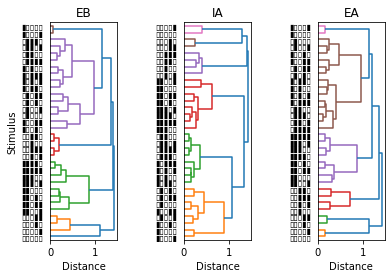

In [13]:
### Ordering the cms by hierarchical clustering
def generate_linkage(cms):
    Z = [linkage(i, 'ward', optimal_ordering=True) for i in cms]
    return Z
def plot_dendrograms(fig, global_gs, cms, glyphs):
    Z = generate_linkage(cms)
    sub_gridspec = global_gs.subgridspec(ncols=3, nrows=1, wspace=1, hspace=0.1)
    titles = ['EB', 'IA', 'EA']
    dends = []
    axs = []
    for i, z in enumerate(Z):
        ax = fig.add_subplot(sub_gridspec[0, i])
        dend = dendrogram(z, ax=ax, labels=glyphs, orientation='right')
        ax.set_title(titles[i])
        ax.set_xlabel('Distance')
        axs.append(ax)
        dends.append(dend)
        if i == 0:
            ax.set_ylabel('Stimulus')
    return dends, axs
# dend = dendrogram(Z, no_plot=True)
# print(dend['leaves'])

# plt.imshow(cms[0][:, dend['leaves']][dend['leaves'], :])
# plt.xticks(range(32), labels=np.array(glyphs)[dend['leaves']], rotation=90);
# plt.yticks(range(32), labels=np.array(glyphs)[dend['leaves']]);
# plt.ylim(31.5, -0.5)

fig = plt.figure()
gs = GridSpec(1, 1)
dends = plot_dendrograms(fig, gs[0], cms, glyphs)



In [28]:
dendrogram(Z, labels=glyphs, leaf_rotation=90, leaf_font_size=8);

NameError: name 'Z' is not defined

In [17]:
half_dict = pickle.Unpickler(open('../Fig5/230425_half_dict.p', 'rb')).load()
### Two halves of the data confusion matrices - each one is constructed from disctinct data from the other
cm_half1 = confusion_matrix(half_dict['trues'].flatten(), half_dict['pred1'].flatten(), normalize='true', labels=range(32))
cm_half2 = confusion_matrix(half_dict['trues'].flatten(), half_dict['pred2'].flatten(), normalize='true', labels=range(32))
fig = plt.figure()
gs = GridSpec(1, 1)
axs = plot_faux_distance_matrices(fig, gs[0], [cm_half1, cm_half2], glyphs, ['Half 1', 'Half 2'], cmap='plasma', rotate=True)


NameError: name 'plot_faux_distance_matrices' is not defined

<Figure size 432x288 with 0 Axes>

In [18]:
### measuring distances between the cms
def plot_cms(cms, ax, cmap='plasma_r'):
    im = ax.imshow(cms[0], cmap=cmap)
    cbar = plt.colorbar(cax=ax, mappable=im)
    cbar.set_ticks(np.linspace(0, 1, len(glyphs)))
    cbar.set_ticklabels(glyphs[::-1])
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    ax.set_xticklabels(glyphs, rotation=90)
    ax.set_yticklabels(glyphs)
    ax.set_ylim(31.5, -0.5)
    ax.set_title('CM')

In [19]:
### faux distance matrices
labs_onset = np.where(em.trial_arrays['cao_array'][:, :5] == 1)[1]
labs_conc = np.where(em.trial_arrays['cao_array'][:, 5:] == 1)[1]
labs_conc = np.append([-1], labs_conc)
labs_onset = np.append([5], labs_onset)

In [17]:
print(em.trial_arrays['cao_array'])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0.

In [20]:
dm_conc = distance_matrix(labs_conc[:, np.newaxis], labs_conc[:, np.newaxis])

In [21]:
dm_onset = distance_matrix(labs_onset[:, np.newaxis], labs_onset[:, np.newaxis])

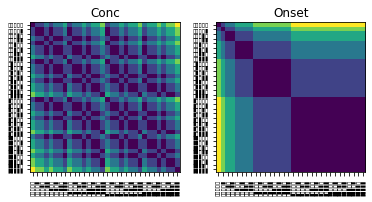

In [22]:
def plot_faux_distance_matrices(fig, glob_gs, dms, glyphs, titles, cmap='viridis', rotate=False, cbar=True, fs=6):
    if cbar:
        sub_gs = glob_gs.subgridspec(ncols=22, nrows=2, hspace=0.3)
    else:
        sub_gs = glob_gs.subgridspec(ncols=20, nrows=2, hspace=0.3)
    axs = []
    max_dm = np.max([np.max(i) for i in dms])
    min_dm = np.min([np.min(i) for i in dms])
    for i, dm in enumerate(dms):
        if rotate:
            ax = fig.add_subplot(sub_gs[:, i*11:(i+1)*9+2*i])
        else:
            ax = fig.add_subplot(sub_gs[i, :20])
        im = ax.imshow(dm, cmap=cmap, vmax=max_dm, vmin=min_dm)
        
        ax.set_xticks(range(32))
        ax.set_yticks(range(32))
        ax.set_yticklabels(glyphs, fontsize=fs)
        ax.set_ylim(31.5, -0.5)
        ax.set_title(titles[i])
        ax.set_xticklabels([])
        axs.append(ax)
    axs[1].set_xticklabels(glyphs, rotation=90, fontsize=fs)
    if rotate:
        #axs[1].set_yticklabels([])
        axs[0].set_xticklabels(glyphs, rotation=90, fontsize=fs)
    if cbar:
        cbar_ax = fig.add_subplot(sub_gs[:, -1])
        colorbar = fig.colorbar(im, cax=cbar_ax)
    return axs, im
fig = plt.figure()
gs = GridSpec(1, 1)
axs = plot_faux_distance_matrices(fig, gs[0], [dm_conc, dm_onset], glyphs, ['Conc', 'Onset'], rotate=True, cbar=False)


In [23]:
def loss(x):
    combo_dm = x[0]*dm_conc + x[1]*dm_onset
    return np.sum((combo_dm-cms[0])**2)
opt = scipy.optimize.minimize(loss, np.ones(2), method='Nelder-Mead')

In [24]:
def full_loss(x):
    ws = x @ em.trial_arrays['cao_array'].T
    dm = distance_matrix(ws[:, np.newaxis], ws[:, np.newaxis])
    return 1 - abs(np.corrcoef(dm.ravel(), cms[0].ravel())[0, 1])
    return np.sum((dm - (1-cms[0]))**2)
opt = scipy.optimize.minimize(full_loss, np.ones(10), method='Nelder-Mead', options={'maxiter':10000})

 final_simplex: (array([[ 5.04277524,  2.93242074,  0.97627917, -0.00894722, -0.02522166,
         0.13776936,  0.13776937,  0.38148149,  1.18343106,  1.29331181],
       [ 5.04268709,  2.93236949,  0.97630248, -0.00892222, -0.02519839,
         0.13778898,  0.13778898,  0.38148602,  1.18343148,  1.29327611],
       [ 5.04280811,  2.93239794,  0.97631695, -0.00893137, -0.02519838,
         0.13775748,  0.13775747,  0.38145245,  1.18340371,  1.29327534],
       [ 5.04270125,  2.93236184,  0.97629239, -0.00893484, -0.02521626,
         0.1378006 ,  0.1378006 ,  0.38152357,  1.18343741,  1.29335682],
       [ 5.04280895,  2.93240666,  0.97631885, -0.0089414 , -0.02520952,
         0.13775537,  0.13775537,  0.38148349,  1.18346986,  1.29329629],
       [ 5.0427309 ,  2.93238625,  0.97629732, -0.00895273, -0.02523592,
         0.13778886,  0.13778886,  0.38149662,  1.18345183,  1.29332954],
       [ 5.04286557,  2.93244876,  0.97629389, -0.00898563, -0.02526578,
         0.1377547 ,  0.1377

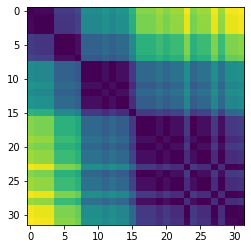

In [25]:
preds = opt.x @ em.trial_arrays['cao_array'].T
dm = distance_matrix(preds[:, np.newaxis], preds[:, np.newaxis])
plt.imshow(dm)
print(opt)
print(np.corrcoef(dm.ravel(), cms[0].ravel())[0, 1])

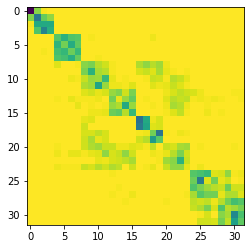

In [24]:
plt.imshow(1-cms[0])

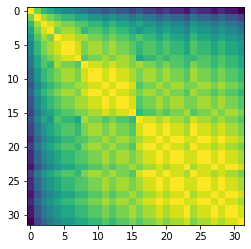

In [25]:
plt.imshow(opt.x[0]*dm_conc + opt.x[1]*dm_onset)

In [26]:
faux_corrs = np.corrcoef([dm_conc.flatten(), dm_onset.flatten(), cms[0].flatten(), cms[1].flatten(), cms[2].flatten()])[:2, 2:].flatten()
print(np.mean(faux_corrs), np.std(faux_corrs))

-0.2708242674629909 0.054964200101052685


32
32
32
32


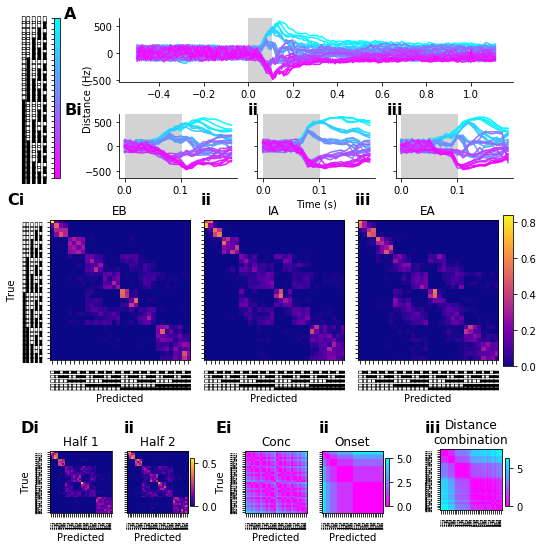

In [28]:
fig = plt.figure(figsize=(8.3, 10))
gs = GridSpec(3,1)
distance_axs = distance_plots(fig, gs[0], xs, np.array([closests1, closests2, closests3]), cmap=matplotlib.cm.cool)
sub_gs = gs[1].subgridspec(ncols=31, nrows=1, wspace=0.5)
ims, heatmap_axs = plot_all_heatmaps(fig, sub_gs[:-1], cms)
cbar_ax = fig.add_subplot(sub_gs[-1], aspect=15)
cbar = fig.colorbar(ims[0], cax=cbar_ax)
[i.spines['right'].set_visible(False) for i in distance_axs]
[i.spines['top'].set_visible(False) for i in distance_axs]

sub_gs = gs[2].subgridspec(1, 29, wspace=1)
#dends, dend_axs = plot_dendrograms(fig,sub_gs[:-1], cms, glyphs)
combo_ax = fig.add_subplot(sub_gs[-5:-1])
combo_cbax = fig.add_subplot(sub_gs[-1])
im = combo_ax.imshow(dm, cmap='cool_r')
combo_ax.set_xticks(range(32))
combo_ax.set_yticks(range(32))
combo_ax.set_yticklabels(glyphs, fontsize=3)
combo_ax.set_ylim(31.5, -0.5)
combo_ax.set_xticks(range(32))
combo_ax.set_xticklabels(glyphs, rotation=90, fontsize=3)
plt.colorbar(im, cax=combo_cbax)
combo_ax_cbar = combo_cbax.get_position()
new_pos = [combo_ax_cbar.x0, combo_ax_cbar.y0+(combo_ax_cbar.height/2)-(combo_ax_cbar.height*0.3/2), combo_ax_cbar.width*0.5, combo_ax_cbar.height*0.3]
combo_cbax.set_position(new_pos)

dm_axs, dm_im = plot_faux_distance_matrices(fig, sub_gs[12:21], [dm_conc, dm_onset], glyphs, ['Conc', 'Onset'], rotate=True, cmap='cool_r', cbar=False, fs=3)
half_axs, half_dm = plot_faux_distance_matrices(fig, sub_gs[:9], [cm_half1, cm_half2], glyphs, ['Half 1', 'Half 2'], rotate=True, cmap='plasma', cbar=False, fs=3)
dm_cbar = fig.add_subplot(sub_gs[21])
dm_cbar_pos = dm_cbar.get_position()
new_pos = [dm_cbar_pos.x0-0.01, dm_cbar_pos.y0+(dm_cbar_pos.height/2)-(dm_cbar_pos.height*0.3/2), dm_cbar_pos.width*0.5, dm_cbar_pos.height*0.3]
dm_cbar.set_position(new_pos)
dm_cbar_im = fig.colorbar(dm_im, cax=dm_cbar)
dm_axs[1].set_yticklabels([])
dm_axs[0].set_xlabel('Predicted')
dm_axs[1].set_xlabel('Predicted')
dm_axs[0].set_ylabel('True')

half_cbar = fig.add_subplot(sub_gs[9])
half_cbar_pos = half_cbar.get_position()
new_pos = [half_cbar_pos.x0-0.01, half_cbar_pos.y0+(half_cbar_pos.height/2)-(half_cbar_pos.height*0.3/2), half_cbar_pos.width*0.5, half_cbar_pos.height*0.3]
half_cbar.set_position(new_pos)
half_cbar_im = fig.colorbar(half_dm, cax=half_cbar)
half_axs[1].set_yticklabels([])
half_axs[0].set_xlabel('Predicted')
half_axs[1].set_xlabel('Predicted')
half_axs[0].set_ylabel('True')

combo_ax.set_position([combo_ax.get_position().x0, combo_ax.get_position().y0, half_axs[0].get_position().width, half_axs[0].get_position().height])
combo_ax.set_title('Distance\ncombination')
axes = [*distance_axs, *heatmap_axs, *dm_axs, *half_axs, combo_ax, combo_cbax, dm_cbar, half_cbar]
labels = ['A', 'Bi', 'ii', 'iii', 'Ci', 'ii', 'iii', 'Ei', 'ii', 'Di', 'ii', 'iii']
align_x = [[0, 1]]
align_y = [[1, 2, 3], [4, 5, 6], [7, 8, 9, 10, 11]]
dx = [-0.035, -0.035, -0.01, -0.01, 0, 0, 0, 0, 0, 0, 0, 0]
label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', dx=dx)
plt.savefig('230703_fig3.pdf', bbox_inches='tight')